In [12]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, roc_curve, 
                            classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler

The raw data was obtained manually with the following link https://zenodo.org/records/14007626

In [13]:
# Parameters
sample_size = 3000  # Cells per pseudobulk
use_all_cells = True  # Since we use ss data, there can be even less cells per patient, so we have to use all in this case
test_size = 0.3  
random_state = 42  # Для воспроизводимости

# Genes of interest
genes_of_interest = ["CXCL8", "CSF2", "TGFB1", "CSF3", "TIMP1", 
                    "IL1B", "PECAM1", "FGF2", "IL6", "CCL2"]

adata = sc.read('TAURUS_raw_counts_annotated_final.h5ad')



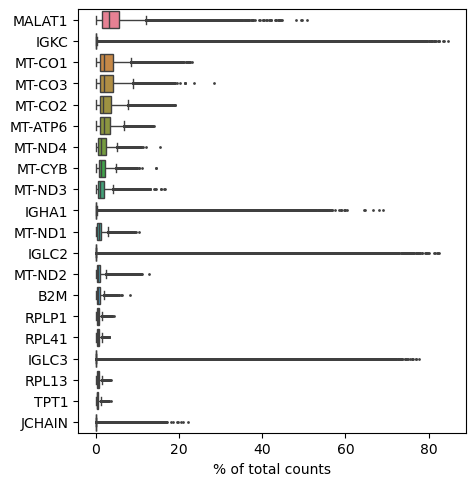

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
# Preprocessing with standard parameters
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [15]:
# filter cd patients with known status
adata_cd = adata[adata.obs['Disease'] == 'CD'].copy()
adata_cd = adata_cd[adata_cd.obs['Remission_status'].isin(['Remission', 'Non_Remission'])].copy()

genes_found = [gene for gene in genes_of_interest if gene in adata_cd.var_names]
print(f"Genes found: {len(genes_found)}/{len(genes_of_interest)}")

# Find unique patients
patients = adata_cd.obs['Patient'].unique()
print(f"Зф: {len(patients)}")

Genes found: 10/10
Зф: 16


ROC-AUC для отдельных генов:
IL1B: 0.667
IL6: 0.600
CXCL8: 0.567
CSF3: 0.500
TIMP1: 0.450
CSF2: 0.367
TGFB1: 0.300
PECAM1: 0.267
FGF2: 0.183
CCL2: 0.167


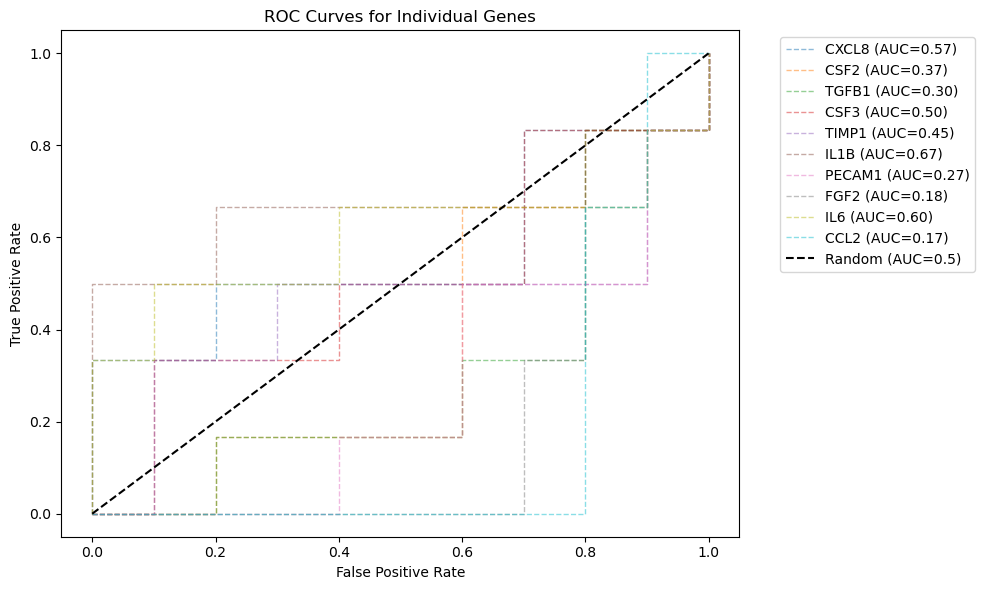

<Figure size 640x480 with 0 Axes>

In [16]:
np.random.seed(random_state)

# Buliding pseudobulk
X_list = []
y_list = []
patient_ids = []

for patient in patients:
    patient_cells = adata_cd.obs[adata_cd.obs['Patient'] == patient].index
    patient_status = adata_cd.obs.loc[patient_cells[0], 'Remission_status']
    
    if not use_all_cells and len(patient_cells) >= sample_size:
        selected = np.random.choice(patient_cells, size=sample_size, replace=False)
    elif not use_all_cells and len(patient_cells) < sample_size:
        print(f"Пациент {patient} имеет только {len(patient_cells)} клеток. Используются все.")
        selected = patient_cells
    else:
        selected = patient_cells
    
    pseudobulk = pd.Series(adata_cd[selected, genes_found].X.sum(axis=0).A1, index=genes_found)
    X_list.append(pseudobulk)
    y_list.append(0 if patient_status == 'Remission' else 1)
    patient_ids.append(patient)

# Build the mqtrix
X = pd.DataFrame(X_list, index=patient_ids, columns=genes_found)
y = np.array(y_list)

# 1. ROC-AUC anlysis for separate genes
plt.figure(figsize=(10, 6))
roc_results = {}

for gene in genes_found:
    auc = roc_auc_score(y, X[gene])
    roc_results[gene] = auc
    fpr, tpr, _ = roc_curve(y, X[gene])
    plt.plot(fpr, tpr, linestyle='--', alpha=0.5, lw=1,
             label=f'{gene} (AUC={auc:.2f})')

print("ROC-AUC для отдельных генов:")
for gene, auc in sorted(roc_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{gene}: {auc:.3f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Individual Genes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig("../../../images/CD/validation/roc_curves_individual_genes.png", dpi=300)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5


Confusion Matrix:
[[2 1]
 [0 2]]

Cross-validated AUC: 0.850 (±0.200)


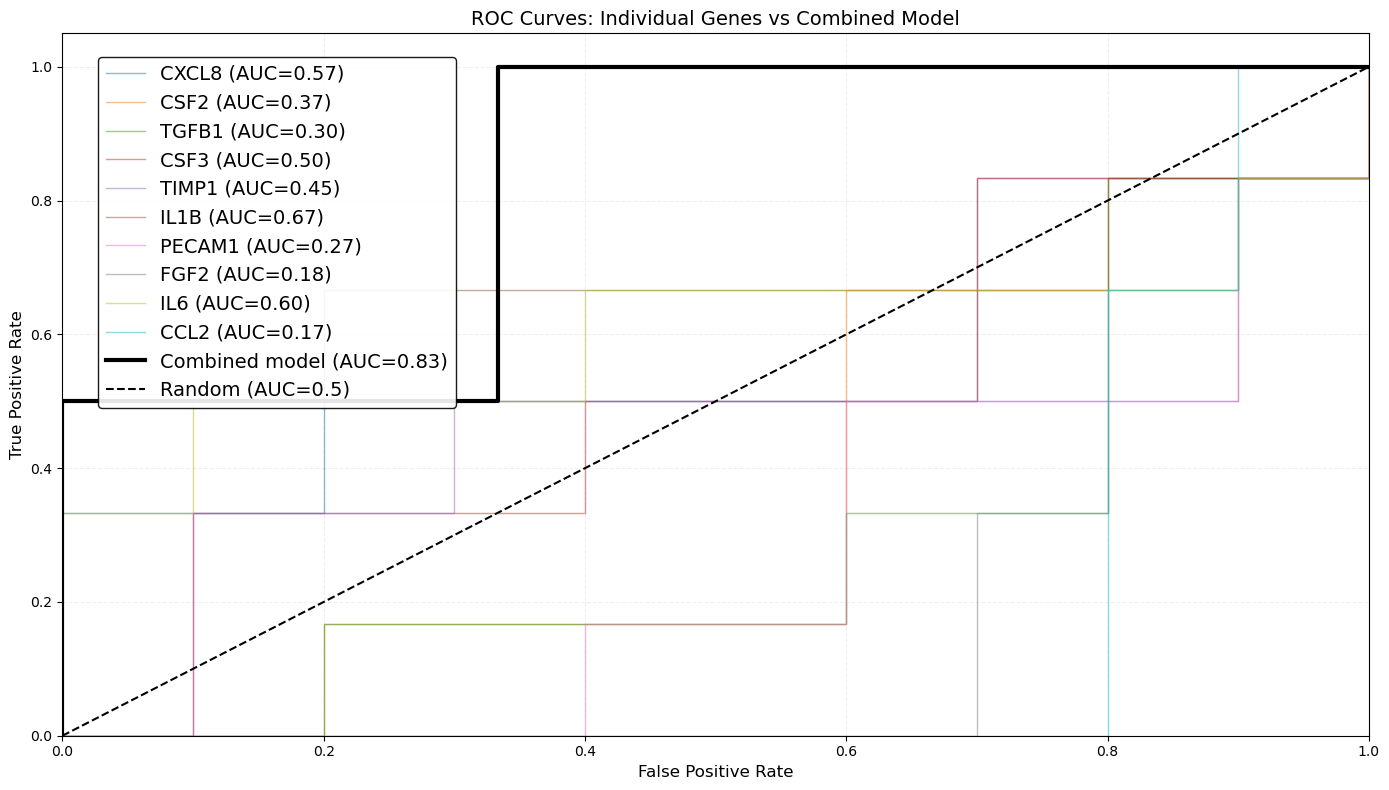

<Figure size 640x480 with 0 Axes>

In [17]:
# 2. Data preaparation for the lr model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Logistic regression model
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
)

logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=random_state,
    class_weight='balanced'
)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Model evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Cross validation
cv_scores = cross_val_score(logreg, X_scaled, y, cv=5, scoring='roc_auc')
print(f"\nCross-validated AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# ROC-curve for logistic regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba)

# 4 Combined plot 
plt.figure(figsize=(14, 8))

# Align individual genes and model
# Plot individual genes
for gene in genes_found:
    fpr, tpr, _ = roc_curve(y, X[gene])
    plt.plot(fpr, tpr, linestyle='-', lw=1, alpha=0.5,
             label=f'{gene} (AUC={roc_results[gene]:.2f})')

# Plot combined model
plt.plot(fpr_lr, tpr_lr, color='black', lw=3,
         label=f'Combined model (AUC={roc_auc_lr:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Individual Genes vs Combined Model', fontsize=14)

legend = plt.legend(loc='upper left', fontsize=14, 
                   frameon=True, framealpha=0.9, 
                   edgecolor='black', facecolor='white',
                   bbox_to_anchor=(0.02, 0.98)) 

plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()
plt.savefig("../../../images/CD/validation/roc_combined_model_vs_genes.png", dpi=300)


Gene Coefficients (Logistic Regression):
     Gene  Coefficient
5    IL1B     0.570815
9    CCL2    -0.514231
8     IL6     0.508170
0   CXCL8     0.366406
4   TIMP1    -0.345461
6  PECAM1    -0.299899
7    FGF2    -0.208101
2   TGFB1    -0.199498
1    CSF2     0.144321
3    CSF3     0.100789


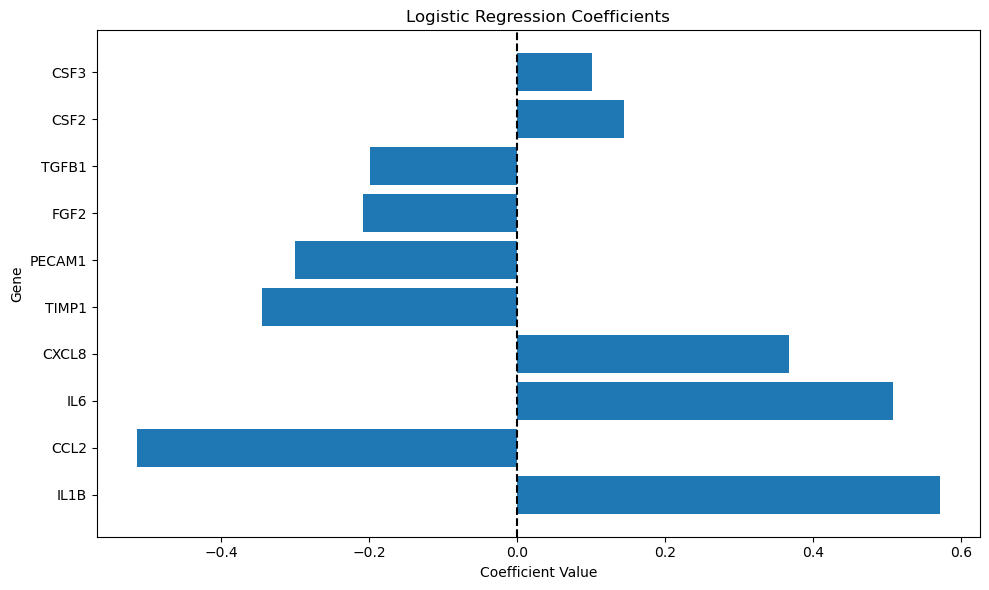

<Figure size 640x480 with 0 Axes>

In [18]:
# 5. Build the "importance graph"

coefficients = pd.DataFrame({
    'Gene': genes_found,
    'Coefficient': logreg.coef_[0],
    'Abs_Coeff': np.abs(logreg.coef_[0])
}).sort_values('Abs_Coeff', ascending=False)
# 6. Analyze gene significance
coefficients = pd.DataFrame({
    'Gene': genes_found,
    'Coefficient': logreg.coef_[0],
    'Abs_Coeff': np.abs(logreg.coef_[0])
}).sort_values('Abs_Coeff', ascending=False)

print("\nGene Coefficients (Logistic Regression):")
print(coefficients.drop('Abs_Coeff', axis=1))

plt.figure(figsize=(10, 6))
plt.barh(coefficients['Gene'], coefficients['Coefficient'])
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()
plt.savefig("../../../images/CD/validation/logreg_coefficients.png", dpi=300)